In [1]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import albumentations as A

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

val_masks = np.load('/kaggle/input/covid-segmentation/masks_medseg.npy').astype(int)
val_imgs = np.load('/kaggle/input/covid-segmentation/images_medseg.npy').astype(float)

train_masks = np.load('/kaggle/input/covid-segmentation/masks_radiopedia.npy').astype(int)
train_imgs = np.load('/kaggle/input/covid-segmentation/images_radiopedia.npy').astype(float)

print(train_imgs.shape, val_imgs.shape, train_masks.shape, val_masks.shape)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


(829, 512, 512, 1) (100, 512, 512, 1) (829, 512, 512, 4) (100, 512, 512, 4)


In [3]:
train_imgs[200].min(), train_imgs[200].max() # requires min-max scaling before preprocessing

(-1353.9586181640625, 175.99066162109375)

0 1
0 0
0 1
0 1


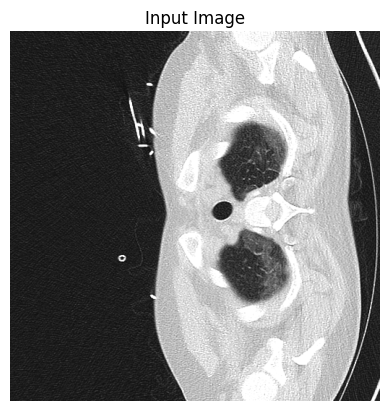

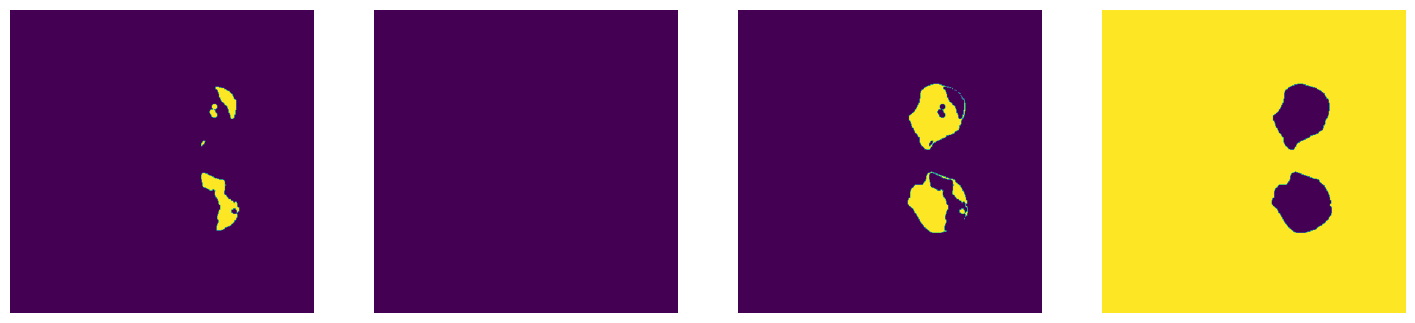

In [4]:
plt.figure()
plt.axis("off")
plt.imshow(train_imgs[145], cmap='gray')
plt.title("Input Image")

plt.figure(figsize=(18, 6))
for i in range(4):
    plt.subplot(141 + i)
    plt.axis("off")
    plt.imshow(train_masks[145, :, :, i])
    print(train_masks[145, :, :, i].min(), train_masks[145, :, :, i].max())

In [5]:
# Load pretrained model and preprocessing function
checkpoint = "smp-hub/segformer-b4-512x512-ade-160k"
model = smp.from_pretrained(checkpoint, classes=4, strict=False).eval().to(device)
preprocessing = A.Compose.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/257M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/segmentation_models_pytorch/base/model.py:137: UserWarning: 

 !!!!!! Mismatched keys !!!!!!

You should TRAIN the model to use it:
 - segmentation_head.0.bias: torch.Size([150]) (weights) -> torch.Size([4]) (model)
 - segmentation_head.0.weight: torch.Size([150, 768, 1, 1]) (weights) -> torch.Size([4, 768, 1, 1]) (model)

  warnings.warn(text, stacklevel=-1)


albumentations_config_eval.json:   0%|          | 0.00/456 [00:00<?, ?B/s]

In [6]:
img = train_imgs[0][:, :, 0]
img = np.stack([img, img, img], axis=-1)
img.shape

(512, 512, 3)

In [7]:
class LungSegDataset(torch.utils.data.Dataset):
    def __init__(self, imgs, masks, transform=None):
        self.imgs = imgs
        self.masks = masks
        self.transform = transform
        
    def __getitem__(self, idx):
        img = self.imgs[idx][:, :, 0]
        mask = self.masks[idx]

        img = np.clip(img, -1500, 500) # Lung region
        img = (img + 1500) / 2000  # Normalize to [0,1]

        img = np.stack([img, img, img], axis=-1)
        
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
        
        return img, mask
    
    def __len__(self):
        return len(self.imgs)

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define augmentations
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.Resize(256, 256),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [9]:
from torch.utils.data import DataLoader

train_dataset = LungSegDataset(train_imgs, train_masks, train_transform)
val_dataset = LungSegDataset(val_imgs, val_masks, val_transform)


train_loader = DataLoader(train_dataset, 8, shuffle=True)
val_loader = DataLoader(val_dataset, 8, shuffle=True)

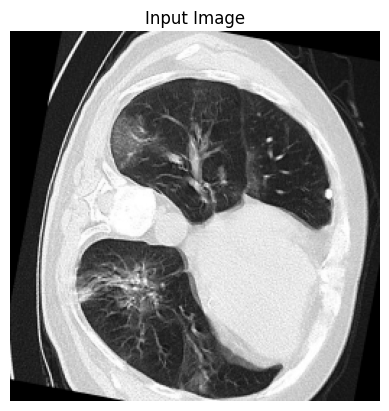

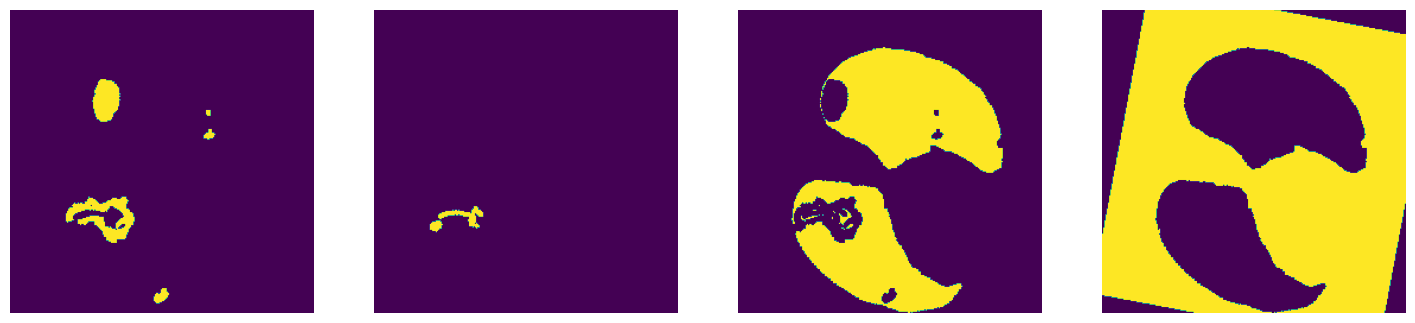

In [10]:
img, mask = train_dataset[20]

img = img[0]

plt.figure()
plt.axis("off")
plt.imshow(img, cmap='gray')
plt.title("Input Image")

plt.figure(figsize=(18, 6))
for i in range(4):
    plt.subplot(141 + i)
    plt.axis("off")
    plt.imshow(mask[:, :, i])

In [11]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [12]:
torch.cuda.empty_cache()

In [13]:
from torchmetrics.classification import MulticlassJaccardIndex
from tqdm import tqdm


for epoch in range(10):
    model.train()

    metric = MulticlassJaccardIndex(num_classes=4, average="macro").to(device)
    train_loss = 0 
    
    for imgs, masks in tqdm(train_loader):
        imgs, masks = imgs.cuda(), masks.cuda().float()

        optimizer.zero_grad()

        
        out = model(imgs).permute(0, 2, 3, 1)
        preds = out.argmax(dim=-1)  # get predicted class per pixel
        # masks = masks.argmax(dim=-1)
        
        # print(preds.shape, masks.shape) 
        metric.update(preds, masks.argmax(dim=-1))
        
        loss = loss_fn(out, masks)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    miou = metric.compute().item()
    train_loss = train_loss / len(train_loader)
    print(f'Epoch {epoch+1}: train loss: {train_loss}, mean IoU:{miou}')

100%|██████████| 104/104 [02:28<00:00,  1.43s/it]


Epoch 1: train loss: 333.7349651043232, mean IoU:0.19491544365882874


100%|██████████| 104/104 [02:27<00:00,  1.42s/it]


Epoch 2: train loss: 328.50529802762543, mean IoU:0.3748611509799957


100%|██████████| 104/104 [02:28<00:00,  1.43s/it]


Epoch 3: train loss: 326.82657740666315, mean IoU:0.4189426302909851


100%|██████████| 104/104 [02:29<00:00,  1.43s/it]


Epoch 4: train loss: 325.4122082636907, mean IoU:0.4357943534851074


100%|██████████| 104/104 [02:28<00:00,  1.43s/it]


Epoch 5: train loss: 326.49467791043793, mean IoU:0.445948988199234


100%|██████████| 104/104 [02:28<00:00,  1.43s/it]


Epoch 6: train loss: 325.9666246267465, mean IoU:0.4791015386581421


100%|██████████| 104/104 [02:28<00:00,  1.43s/it]


Epoch 7: train loss: 325.926699418288, mean IoU:0.4848010540008545


100%|██████████| 104/104 [02:28<00:00,  1.42s/it]


Epoch 8: train loss: 324.9084839454064, mean IoU:0.49960044026374817


100%|██████████| 104/104 [02:28<00:00,  1.43s/it]


Epoch 9: train loss: 324.75164237389197, mean IoU:0.5112629532814026


100%|██████████| 104/104 [02:28<00:00,  1.43s/it]

Epoch 10: train loss: 325.6344856849083, mean IoU:0.5132404565811157


In [14]:
# Setup metric
miou_metric = MulticlassJaccardIndex(num_classes=4, average="macro").to(device)

# In validation loop
model.eval()
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        # Predictions
        preds = model(imgs)  # [B, 4, H, W]

        # Convert both to class indices
        preds = preds.argmax(dim=1)  # [B, H, W]
        masks = masks.argmax(dim=-1)  # [B, H, W]

        # Update metric
        miou_metric.update(preds, masks)

# After all batches
mean_iou = miou_metric.compute().item()
print(f"Validation Mean IoU: {mean_iou:.4f}")

Validation Mean IoU: 0.4712


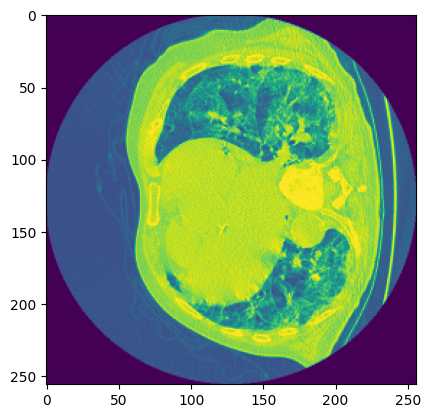

torch.Size([3, 256, 256])
torch.Size([256, 256, 4]) torch.Size([256, 256, 4])


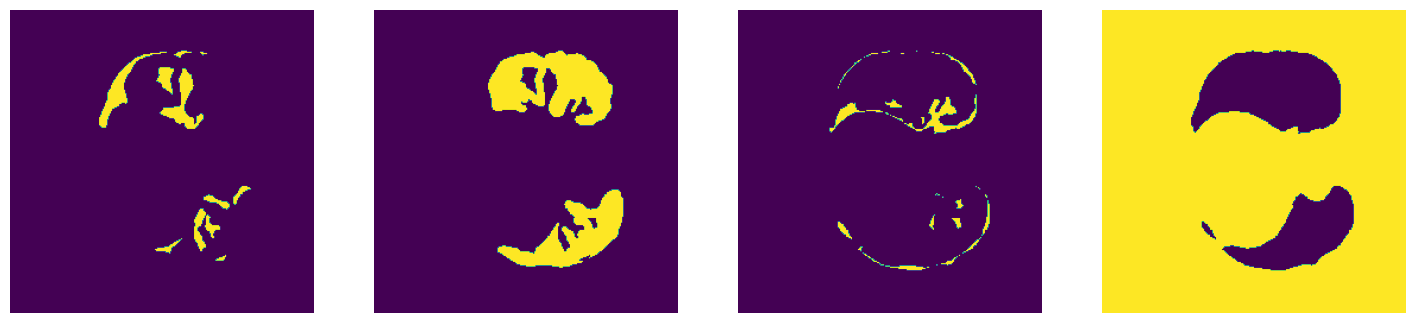

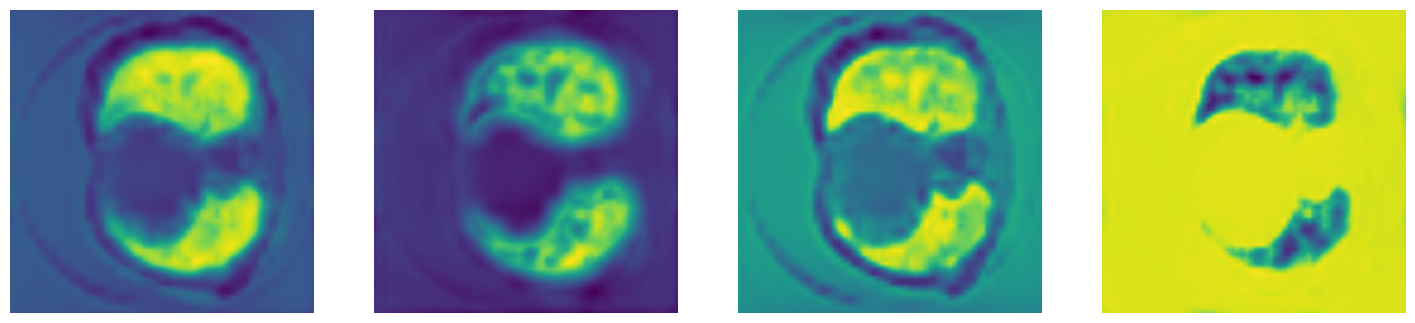

In [15]:
img, mask = val_dataset[0]

img = img[0]

plt.imshow(img)
plt.show()

img = torch.tensor(np.stack([img, img, img], axis=0))

print(img.shape)

# Predictions
model.eval()
model.to('cpu')
with torch.no_grad():
    preds = model(img.unsqueeze(0)).squeeze(0).permute(1, 2, 0).cpu()  # [B, 4, H, W]
    
    print(preds.shape, mask.shape)
    plt.figure(figsize=(18, 6))
    for i in range(4):
        plt.subplot(141 + i)
        plt.axis("off")
        plt.imshow(mask[:, :, i])
    plt.show()
    
    plt.figure(figsize=(18, 6))
    for i in range(4):
        plt.subplot(141 + i)
        plt.axis("off")
        plt.imshow(preds[:, :, i])